In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, recall_score, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('initial_cleaned_winner_data.csv')

X = df.drop('Winner', axis=1)
y = df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate for base model
y_pred_base = model.predict(X_test)
print("Initial Model Classification Report:")
print(classification_report(y_test, y_pred_base))

Initial Model Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1750
        True       0.72      0.72      0.72        82

    accuracy                           0.97      1832
   macro avg       0.85      0.85      0.85      1832
weighted avg       0.97      0.97      0.97      1832



In [11]:
param_grid = {
    'n_estimators': [100, 200, 300, 500, 750, 1000],
    'max_depth': list(range(3, 13, 2)),
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predictions with best model
y_pred = best_model.predict(X_test)

# Print best parameters and classification report
print("Best Parameters:", grid_search.best_params_)
print("\nBest Model Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}

Best Model Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1750
        True       0.81      0.78      0.80        82

    accuracy                           0.98      1832
   macro avg       0.90      0.89      0.89      1832
weighted avg       0.98      0.98      0.98      1832



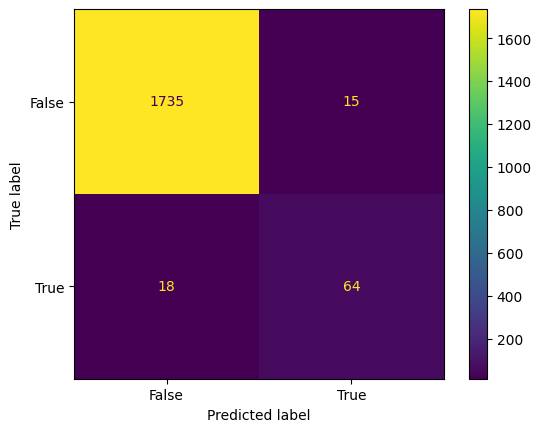

In [14]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

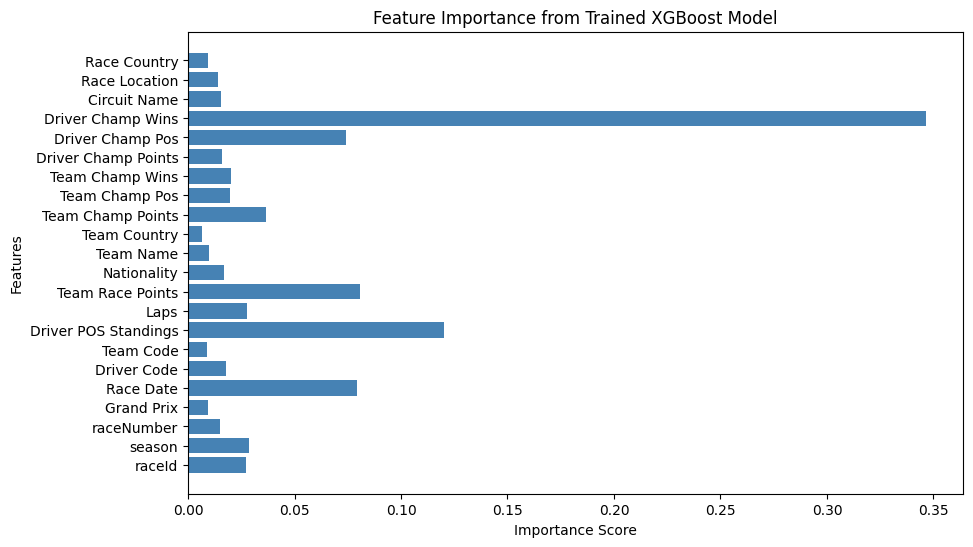

In [15]:
# Feature importance from the trained XGBoost model
feature_importances = best_model.feature_importances_
features = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='steelblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Trained XGBoost Model')
plt.show()


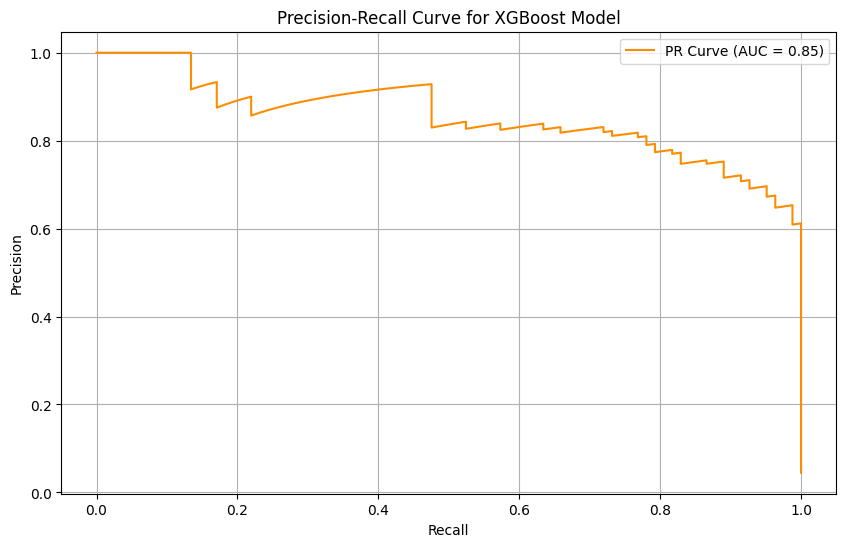

In [19]:
from sklearn.metrics import precision_recall_curve, auc

y_scores = best_model.predict_proba(X_test)[:, 1] 

precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label=1)
pr_auc = auc(recall, precision)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost Model')
plt.legend()
plt.grid()
plt.show()


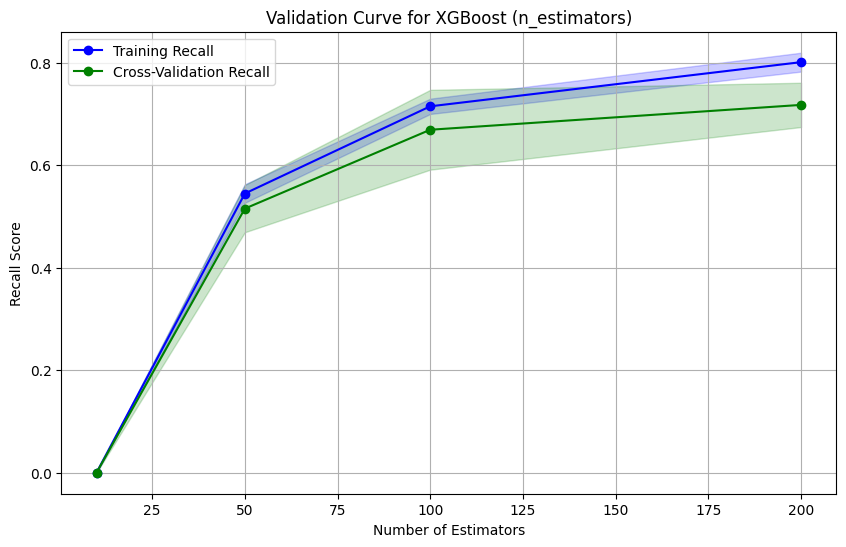

In [22]:
from sklearn.model_selection import validation_curve

param_range = [10, 50, 100, 200]
train_scores, test_scores = validation_curve(
    best_model,
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="recall",
    cv=5
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training Recall', color='blue', marker='o')
plt.plot(param_range, test_mean, label='Cross-Validation Recall', color='green', marker='o')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.xlabel('Number of Estimators')
plt.ylabel('Recall Score')
plt.title('Validation Curve for XGBoost (n_estimators)')
plt.legend()
plt.grid()
plt.show()
